# Annotate gene expression files with ancestry information (mtDNA haplogroup, global nuclear ancestry), mitonuclear DNA discordance, and available phenotypes.

In [1]:
import pandas as pd
#pd.set_option("display.max_rows", None, "display.max_columns", None)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import statistics
import statsmodels.api as sm
from itertools import permutations
#import pdfkit as pdf

import seaborn as sns; sns.set(style="ticks", color_codes=True)

from Bio import SeqIO
import sys

# Local ancestry
- RFMix manual: https://github.com/slowkoni/rfmix/blob/master/MANUAL.md
- Main output: 
    - The most likely assignment of subpopulations per CRF point (<output basename>.msp.tsv).
    - Marginal probabilities of each subpopulation being the ancestral population of the corresponding CRF point (<output basename>.fb.tsv).
        - Zaidi & Makova 2019 used 0.9 posterior prob cutoff for local ancestry estimations.
    - Both output files are tab separated values forming a matrix with rows corresponding to genomic position and columns corresponding to haplotypes (id.0 , id.1).
- Other output:
    - Global diploid ancestry estimates are computed by RFMIX and output to <output basename>.rfmix.Q
    


In [52]:
%%bash
# Most likely assignment of subpopulations.
head -n4 ../data/2021-05-10/rfmixout/rfmixout.13.msp.tsv | cut -f1,2,3,4,5,6,7,8,9,10

# Marginal probabilities of each subpopulation being the ancestral pop.
head -n4 ../data/2021-05-10/rfmixout/rfmixout.13.fb.tsv | cut -f1,2,3,4,5,6,7,8,9,10

# The global ancestry estimates by chromosome provided by RFMix (per individual).
head ../data/2021-05-10/rfmixout/rfmixout.13.rfmix.Q | column -t
ls ../data/2021-05-10/rfmixout/*Q

head ../data/2021-05-10/rfmixout/*22*sis* | cut -f1,2,3,4,5,6

#Subpopulation order/codes: CEU=0	YRI=1
#chm	spos	epos	sgpos	egpos	n snps	GTEX-1117F.0	GTEX-1117F.1	GTEX-111CU.0	GTEX-111CU.1
13	19174634	19634794	0.25	0.86	92	0	1	1	0
13	19634794	19732049	0.86	1.02	30	0	1	1	0
#reference_panel_population:	CEU	YRI
chromosome	physical_position	genetic_position	genetic_marker_index	GTEX-1117F:::hap1:::CEU	GTEX-1117F:::hap1:::YRI	GTEX-1117F:::hap2:::CEU	GTEX-1117F:::hap2:::YRI	GTEX-111CU:::hap1:::CEU	GTEX-111CU:::hap1:::YRI
13	19174634	0.25147	0	1.00000	0.00000	0.00000	1.00000	0.00000	1.00000
13	19264827	0.41475	5	1.00000	0.00000	0.00000	1.00000	0.00000	1.00000
#rfmix      diploid  global   ancestry  .Q  format  output
#sample     CEU      YRI
GTEX-1117F  0.20347  0.79653
GTEX-111CU  0.97393  0.02607
GTEX-111FC  0.86094  0.13906
GTEX-111VG  1.00000  0.00000
GTEX-111YS  0.99333  0.00667
GTEX-1122O  1.00000  0.00000
GTEX-1128S  0.99733  0.00267
GTEX-113IC  0.63612  0.36388
../data/2021-05-10/rfmixout/rfmixout.1.rfmix.Q
../data/2021-05-10/rfmixout/rfmixout.10

('Pearson correlation (European): ',
 (0.9998766016029708, 0.0),
 'Pearson correlation (African): ',
 (0.999876601602971, 0.0))

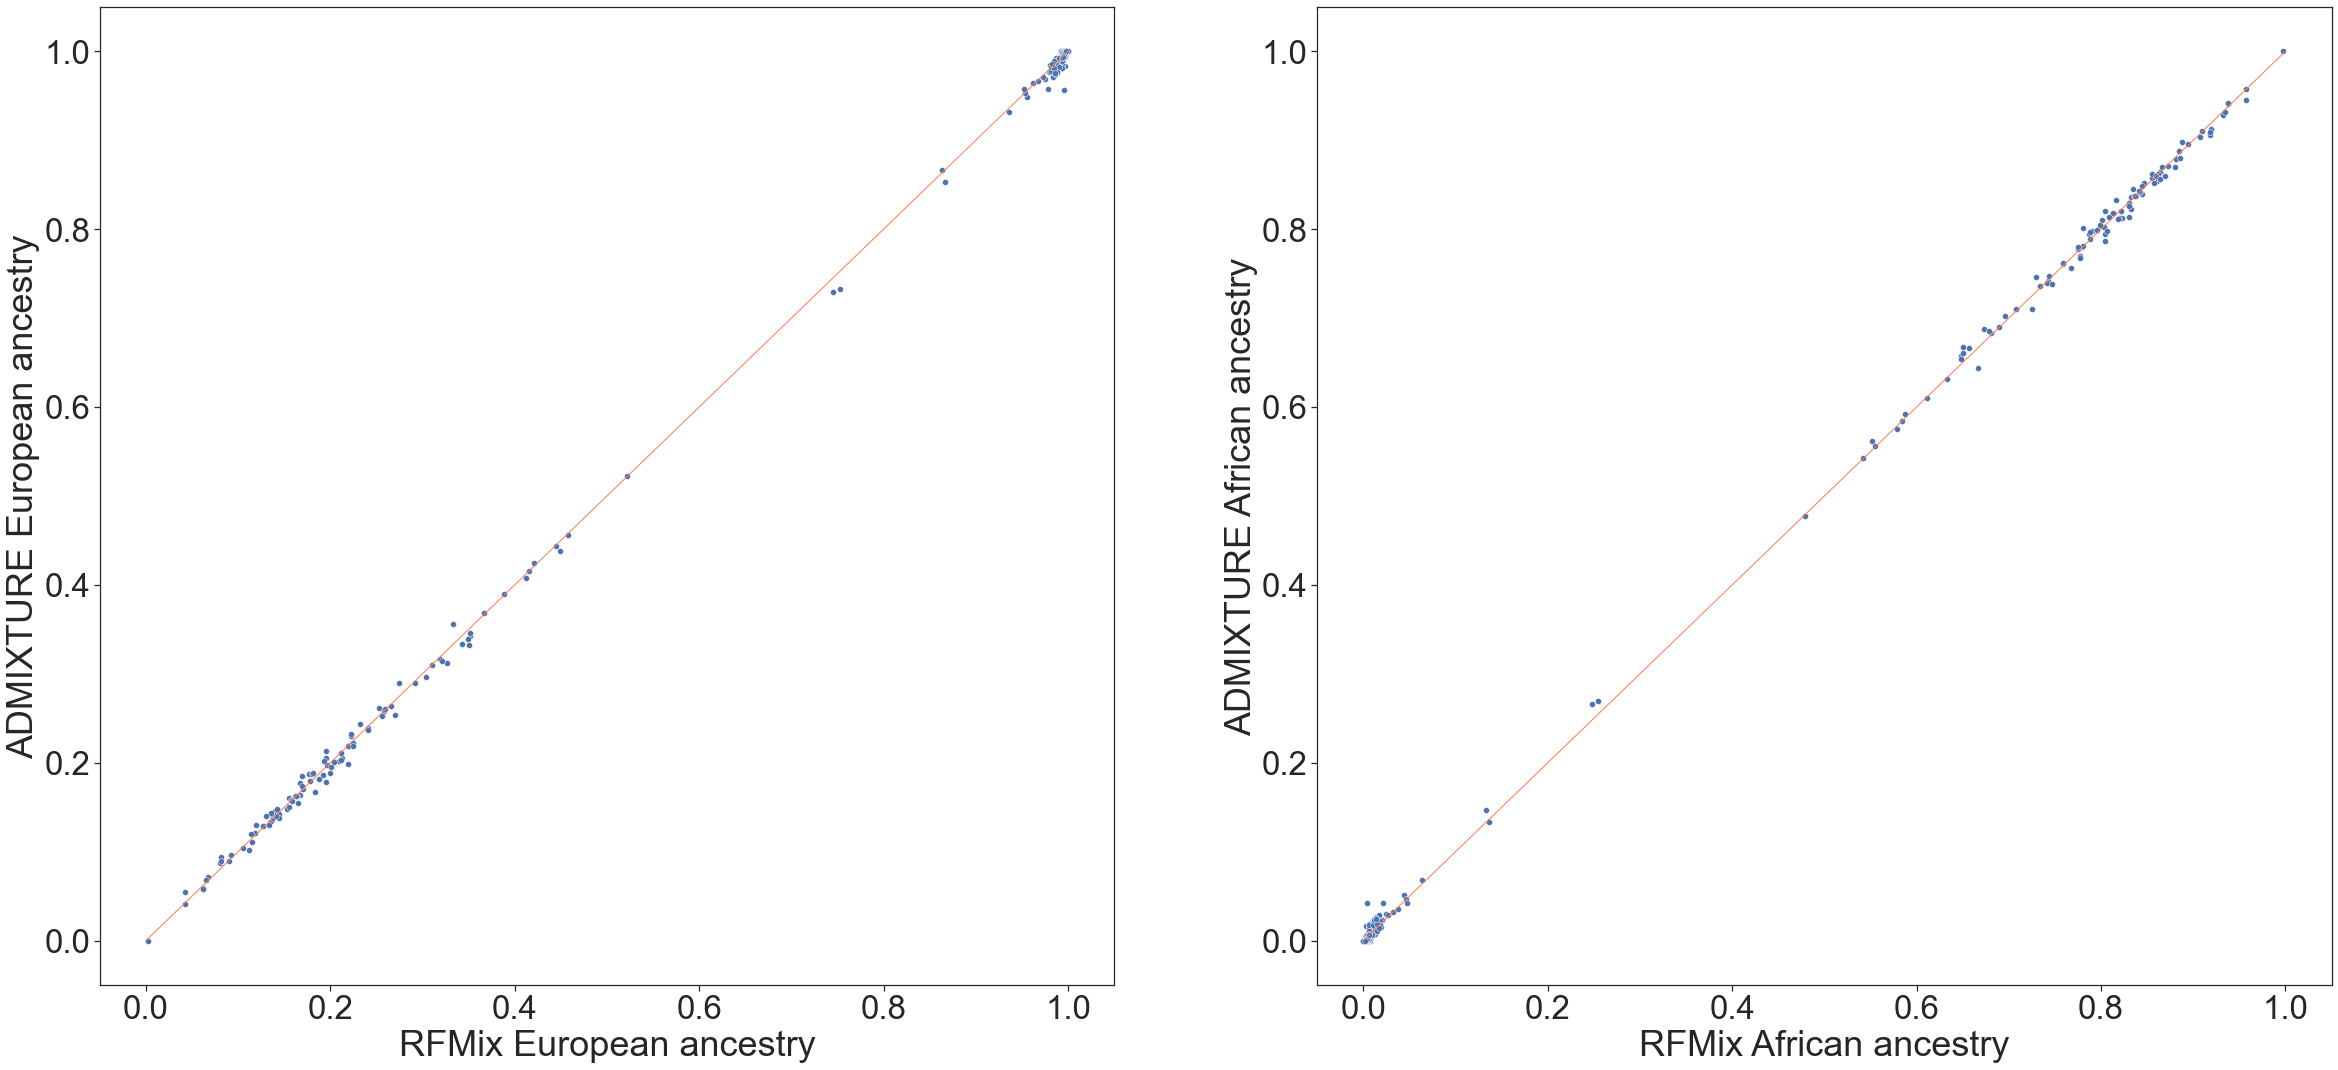

In [53]:
def concat_Qfiles():
    out = pd.DataFrame()
    # Concatenate files with global ancestry estimates at the chromosome-level.
    for CHR in range(1,23):
        one_chr = pd.read_table('../data/2021-05-10/rfmixout/rfmixout.'+str(CHR)+'.rfmix.Q', skiprows=1)
        one_chr.rename(columns={'#sample':'Sample'}, inplace=True)
        # Create a column with the chromosome number for these ancestry estimates.
        one_chr['Chr'] = CHR
        out = out.append(one_chr)
    return(out)


def chr_len_to_prop():
    # The chromosome lengths for GRCh37 / hg19. (https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37) 
    dict_grch37_chr_len = {'1':249250621, '2':243199373, '3':198022430, '4':191154276, '5':180915260, '6':171115067, '7':159138663, '8':146364022, '9':141213431, '10':135534747, '11':135006516, '12':133851895, '13':115169878, '14':107349540, '15':102531392, '16':90354753, '17':81195210, '18':78077248, '19':59128983, '20':63025520, '21':48129895, '22':51304566}
    # Total genome size.
    total_length = sum( dict_grch37_chr_len.values() )
    # Divide the chromsome lengths by the total genome size.
    dict_grch37_chr_prop = {CHR: int(length)/int(total_length) for CHR,length in dict_grch37_chr_len.items()}
    return(dict_grch37_chr_prop)


def rfmix_chr_to_global():
    # The chromosome-level diploid ancestry values.
    all_chr = concat_Qfiles()
    # The weights/proportions for each chromosome.
    dict_grch37_chr_prop = chr_len_to_prop()
    # Weigh the chromosome ancestries with genome-level chrom size proportions.
    out_weighted = pd.DataFrame()
    for CHR in range(1,23):
        weight = dict_grch37_chr_prop[str(CHR)]
        chr_ancestry = all_chr[all_chr['Chr']==CHR][['CEU','YRI']]#.reset_index(drop=True,inplace=True)
        weighted_chr_anc = weight*chr_ancestry
        # Compile the weighted values per chromosome.
        out_weighted = out_weighted.append(weighted_chr_anc)
    all_chr['CEU_weighted'] = out_weighted['CEU']
    all_chr['YRI_weighted'] = out_weighted['YRI']
    #return(all_chr)
    # Combine scores for all chromosomes to get global ancestry.
    out_global = pd.DataFrame()
    for sample in all_chr['Sample'].drop_duplicates():
        data = all_chr[all_chr['Sample']==sample]
        out_global = out_global.append( pd.DataFrame(data={'short_ID':[sample], 'RFMix European ancestry':[sum(data['CEU_weighted'])], 'RFMix African ancestry':[sum(data['YRI_weighted'])]}) )
        #return( pd.DataFrame(data=[sample, sum(data['CEU_weighted']), sum(data['YRI_weighted'])]) )
        #out_global = out_global.append( (sample, sum(data['CEU_weighted']), sum(data['YRI_weighted'])) )
    return(out_global.reset_index(drop=True))


def rfmix_admixture():
    # Join ADMIXTURE and RFMix results.
    df_ADMIXTURE = df_tpm_v8_ann_K2[['short_ID','global_eu','global_af']].drop_duplicates().reset_index(drop=True)
    df_RFMIX = rfmix_chr_to_global()
    df_GLOBAL = pd.merge(df_ADMIXTURE,df_RFMIX, on=['short_ID'])
    df_GLOBAL = df_GLOBAL.rename(columns={'global_eu':'ADMIXTURE European ancestry','global_af':'ADMIXTURE African ancestry'})
    return(df_GLOBAL)


def subplot_rfmix_admixture():
    df_GLOBAL = rfmix_admixture()
    # Compare RFMix to ADMIXTURE global ancestry estimates.
    # Scatter plot with 'y=x' line.
    fig, axes = plt.subplots(1,2, figsize=(40,18), sharex=False, sharey=False)
    ax1 = axes[0]
    sns.scatterplot(data=df_GLOBAL, y='ADMIXTURE European ancestry', x='RFMix European ancestry', ax=ax1)
    ax1.plot([0,1],[0,1],linewidth=1, color='coral')
    ax2 = axes[1]
    sns.scatterplot(data=df_GLOBAL, y='ADMIXTURE African ancestry', x='RFMix African ancestry', ax=ax2)
    ax2.plot([0,1],[0,1],linewidth=1, color='coral')
    # Statistics.
    return("Pearson correlation (European): ",stats.pearsonr(df_GLOBAL['RFMix European ancestry'], df_GLOBAL['ADMIXTURE European ancestry']),
           "Pearson correlation (African): ",stats.pearsonr(df_GLOBAL['RFMix African ancestry'], df_GLOBAL['ADMIXTURE African ancestry']))
    

def cv_error_unsup():
    # Dictionary with CV error values.
    dict_cve = {'1':0.40218,'2':0.36557,'3':0.34939,'4':0.34569,'5':0.34238}
    df_cve = pd.DataFrame.from_dict(dict_cve, orient='index').reset_index()
    df_cve.columns = ['K','CVE']
    #return(df_cve)
    # Plot these values.
    sns.scatterplot(data=df_cve, x='K', y='CVE')
    sns.lineplot(data=df_cve, x='K', y='CVE')
    plt.ylabel('Cross validation error\n')
    
def cv_error_sup():
    # Dictionary with CV error values.
    dict_cve = {'1':0.38083,'2':0.34343,'3':0.34396,'4':0.34506}
    df_cve = pd.DataFrame.from_dict(dict_cve, orient='index').reset_index()
    df_cve.columns = ['K','CVE']
    #return(df_cve)
    # Plot these values.
    sns.scatterplot(data=df_cve, x='K', y='CVE')
    sns.lineplot(data=df_cve, x='K', y='CVE')
    plt.ylabel('Cross validation error\n')
    
def cv_error_norefs():
    # Dictionary with CV error values.
    dict_cve = {'1': 0.36013,'2': 0.33831,'3': 0.33902,'4': 0.34172,'5': 0.34254}
    df_cve = pd.DataFrame.from_dict(dict_cve, orient='index').reset_index()
    df_cve.columns = ['K','CVE']
    #return(df_cve)
    # Plot these values.
    sns.scatterplot(data=df_cve, x='K', y='CVE')
    sns.lineplot(data=df_cve, x='K', y='CVE')
    plt.ylabel('Cross validation error\n')

    
    
#concat_Qfiles()
#chr_len_to_prop()
#rfmix_chr_to_global()
subplot_rfmix_admixture()
#cv_error_norefs()

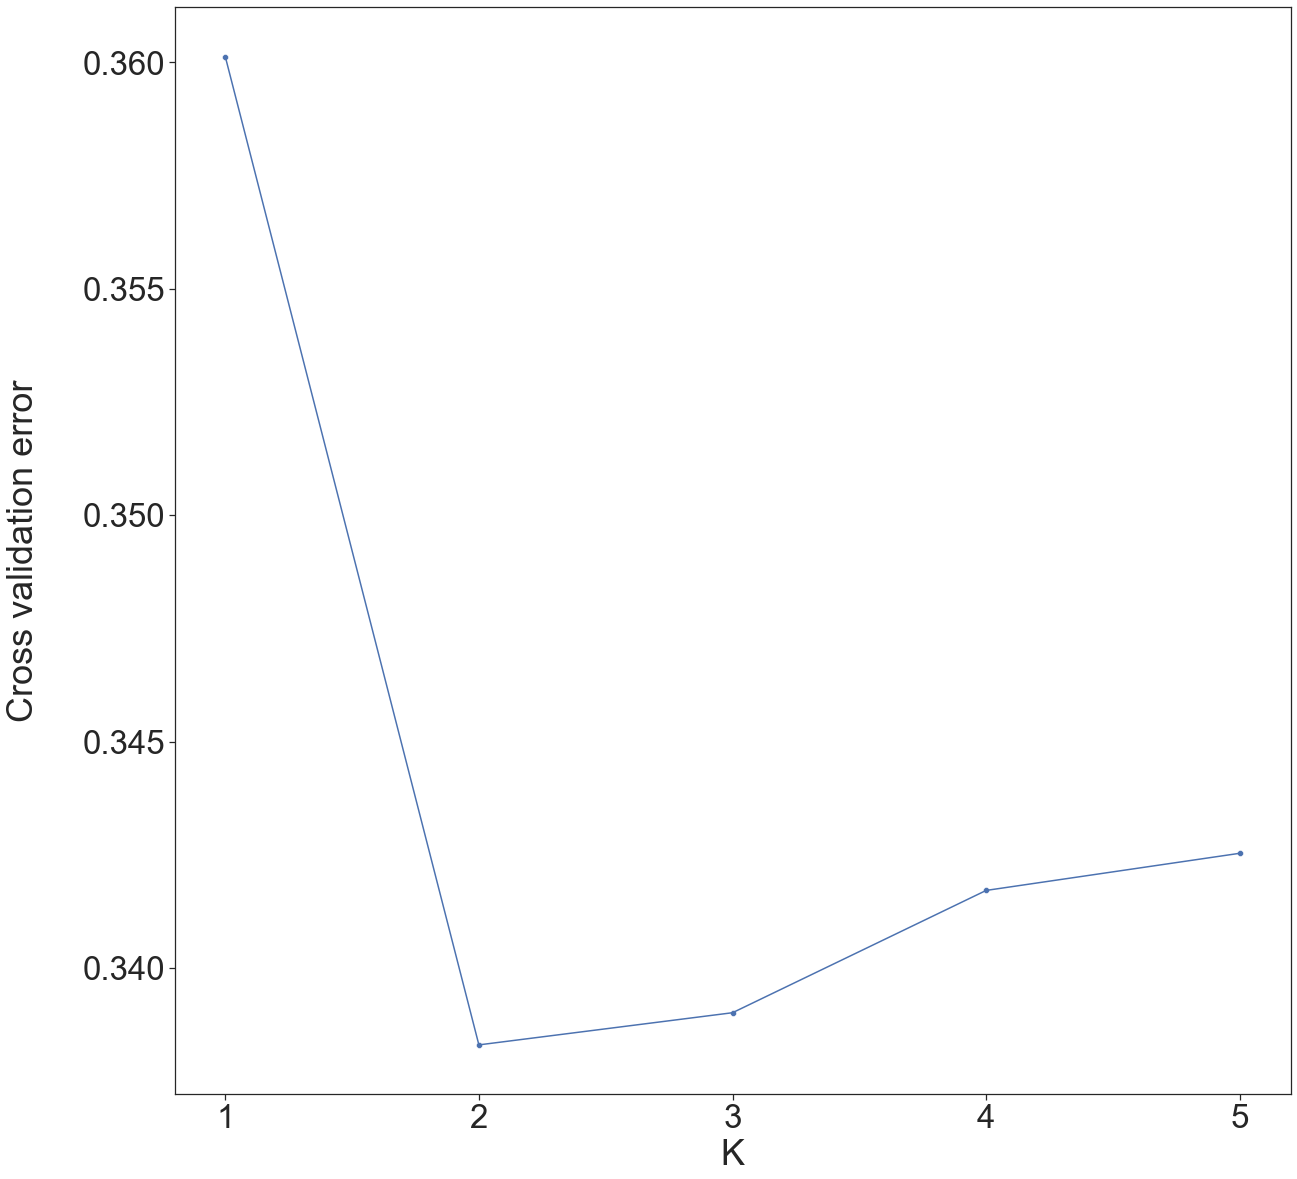

In [54]:
cv_error_norefs()

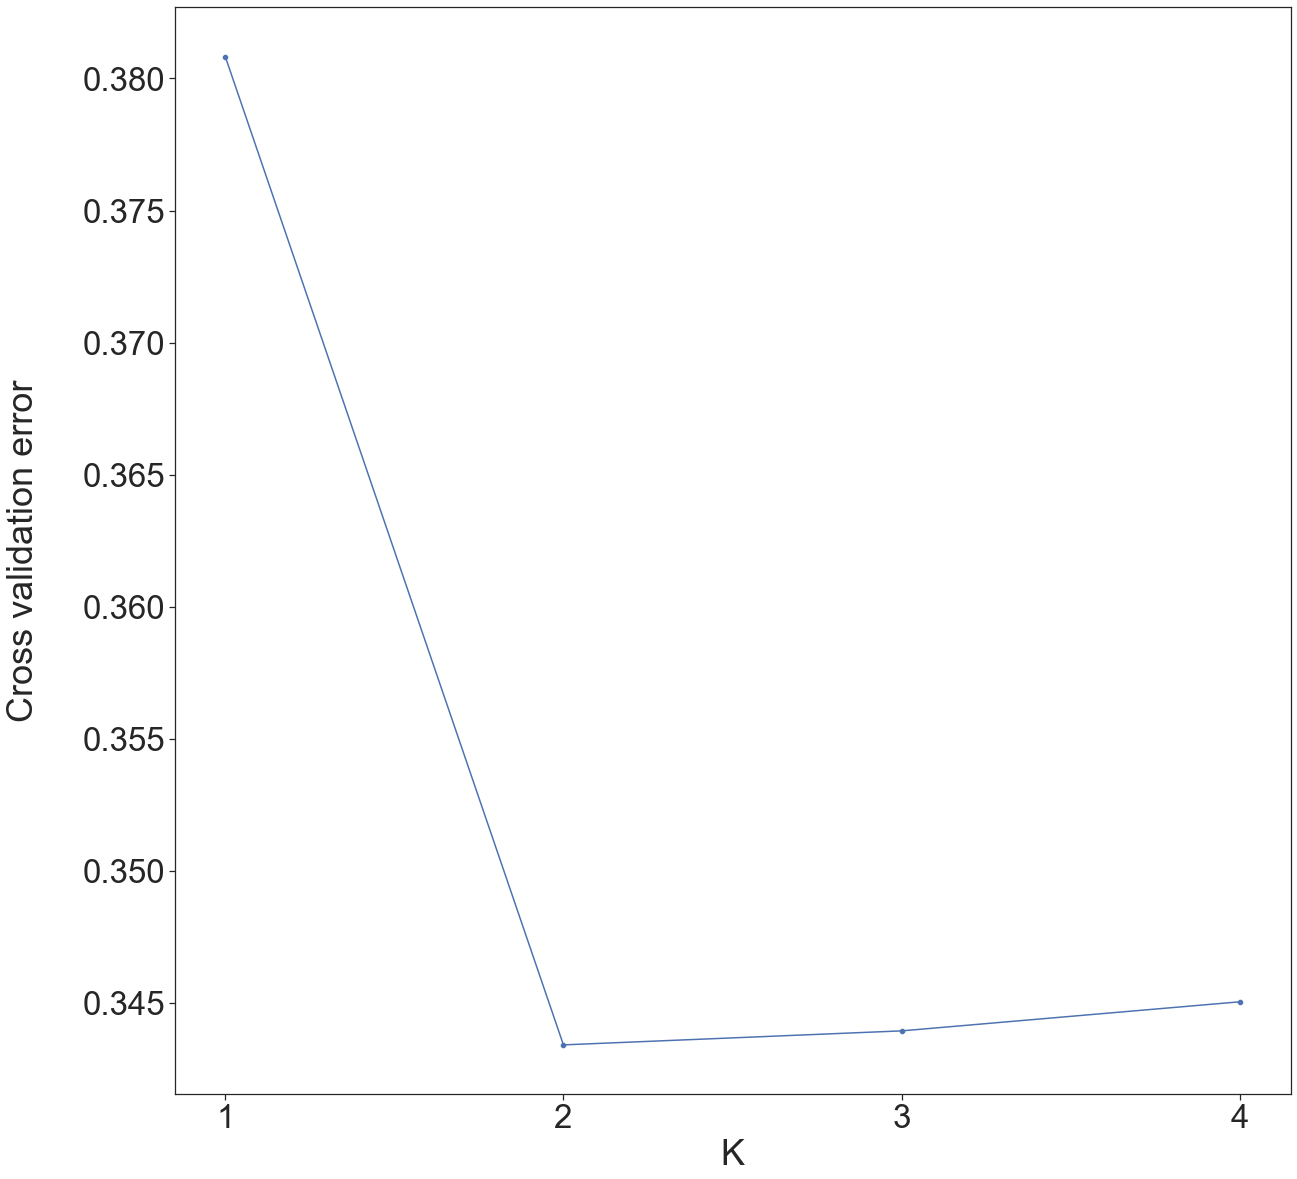

In [55]:
cv_error_sup()

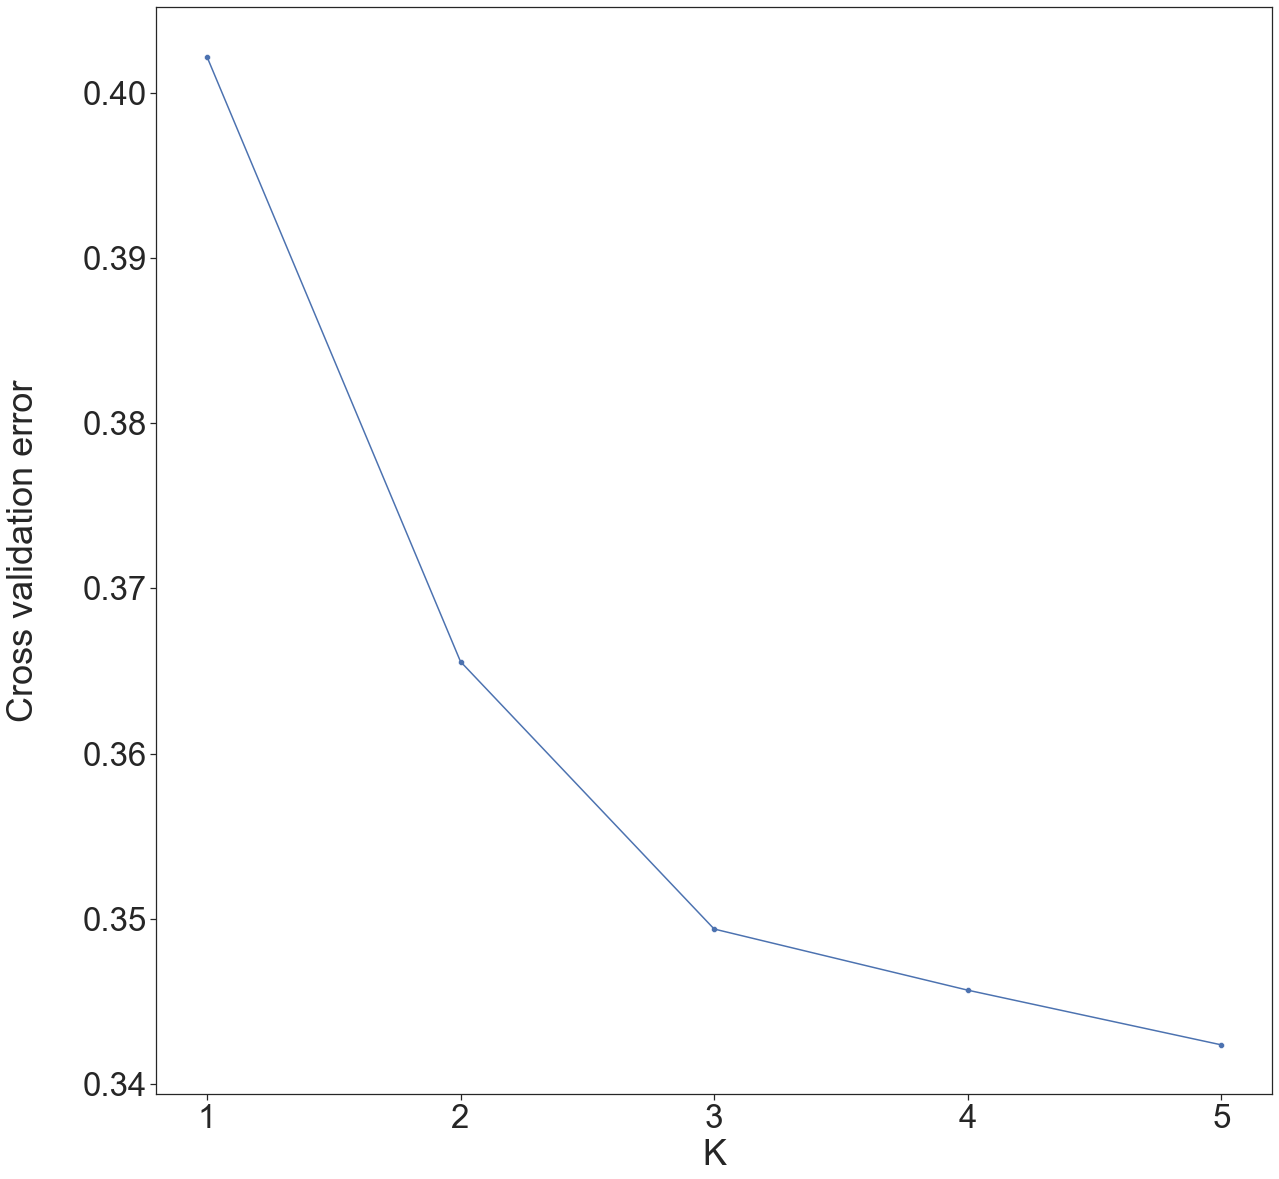

In [56]:
cv_error_unsup()

('Pearson correlation (European): ',
 (0.9998766016029708, 0.0),
 'Pearson correlation (African): ',
 (0.999876601602971, 0.0))

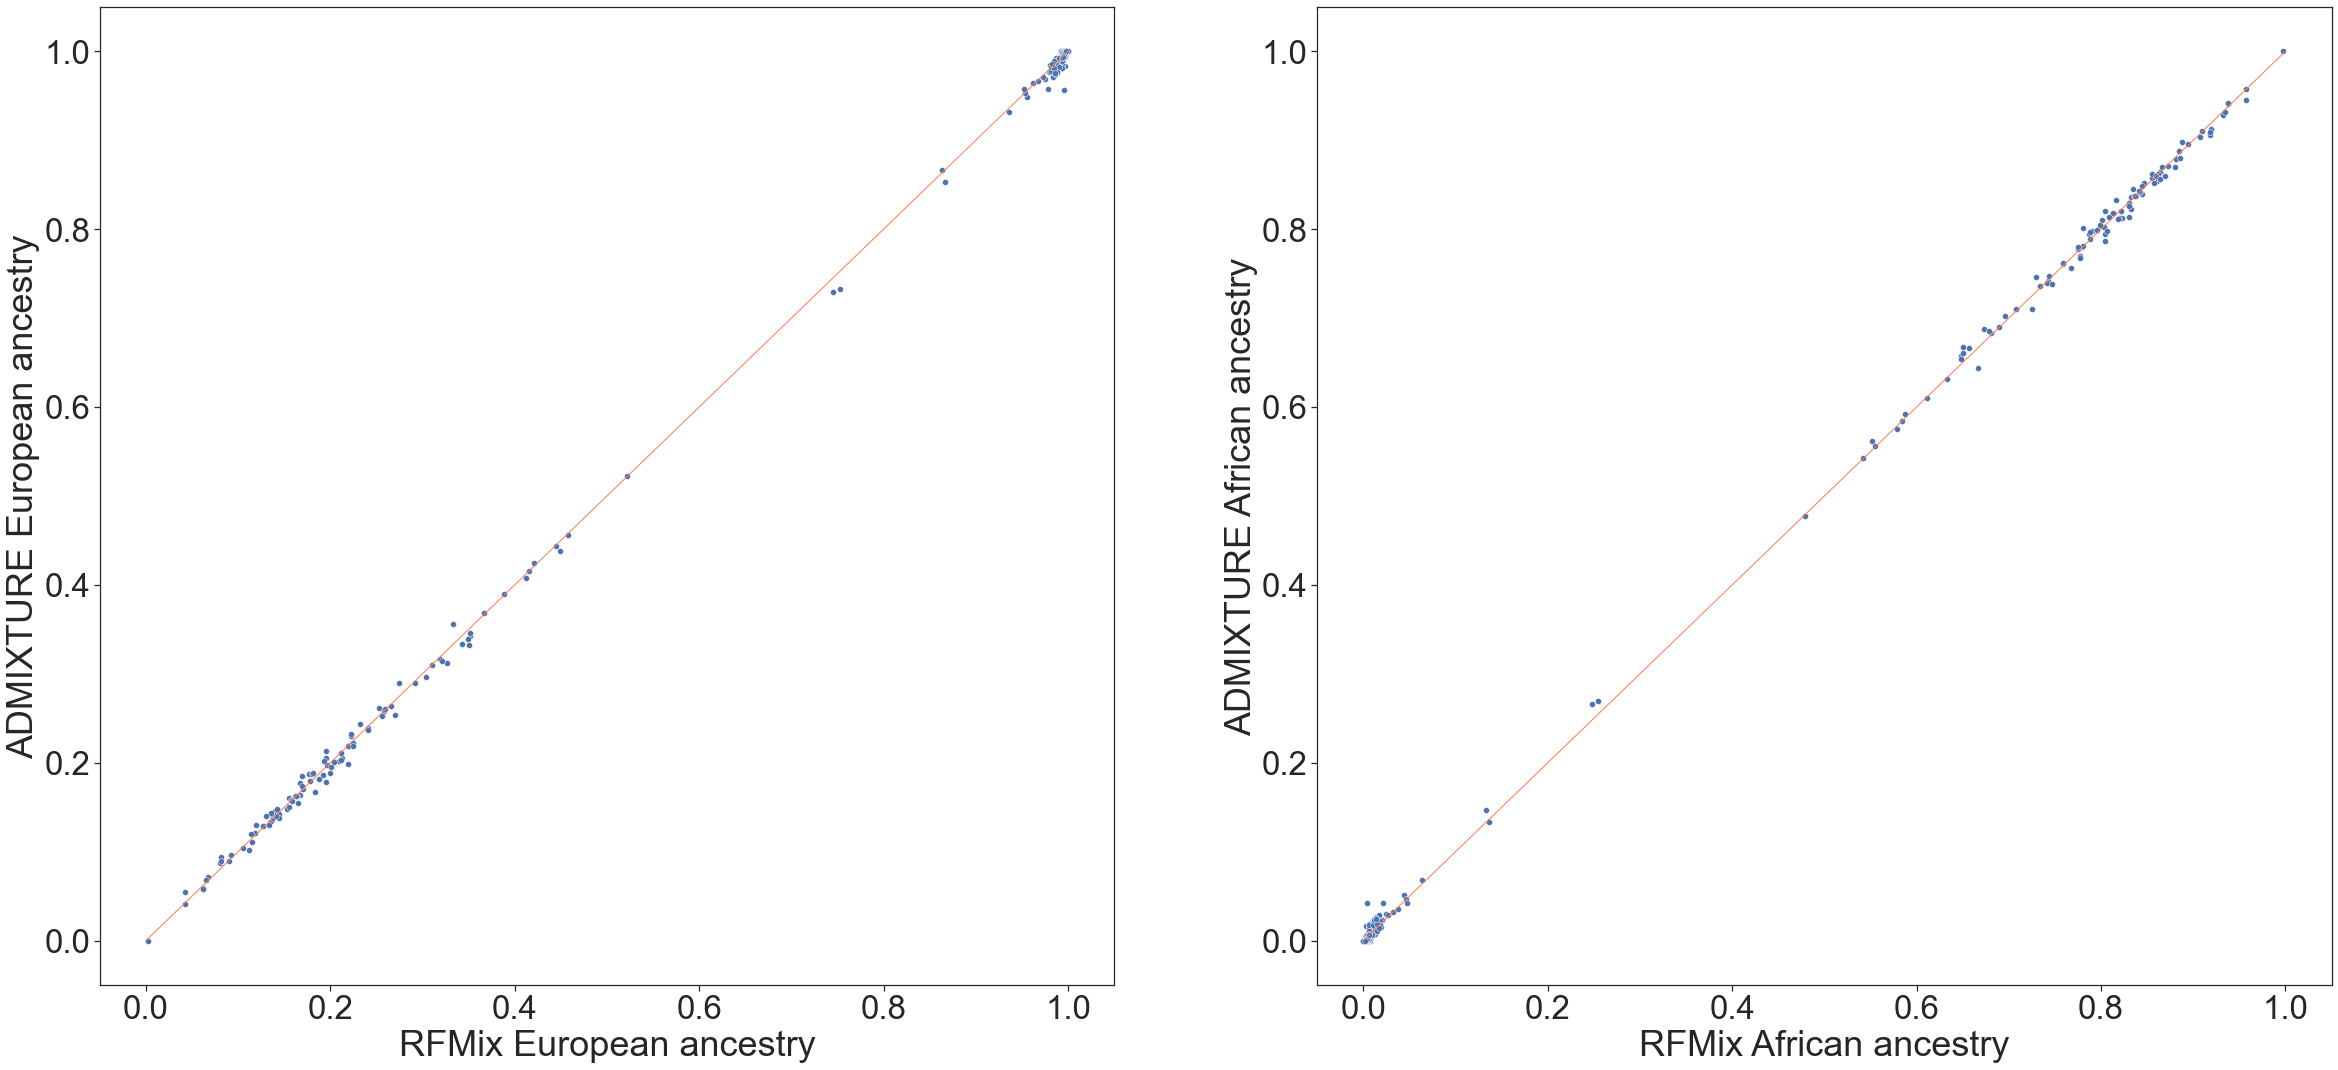

In [57]:
subplot_rfmix_admixture()

In [58]:
rfmix_admixture()

,short_ID,ADMIXTURE European ancestry,ADMIXTURE African ancestry,RFMix European ancestry,RFMix African ancestry
0,GTEX-1117F,0.219452,0.780548,0.220470,0.779530
1,GTEX-111CU,0.976227,0.023773,0.979238,0.020762
2,GTEX-111FC,0.969354,0.030646,0.974794,0.025206
3,GTEX-111VG,0.999990,0.000010,0.998303,0.001697
4,GTEX-111YS,0.999990,0.000010,0.998379,0.001621
...,...,...,...,...,...
784,GTEX-ZYVF,0.992557,0.007443,0.993208,0.006792
785,GTEX-ZYY3,0.993236,0.006764,0.994084,0.005916
786,GTEX-ZZ64,0.999990,0.000010,0.999648,0.000352
787,GTEX-ZZPT,0.999990,0.000010,0.999882,0.000118


# Remake the global ancestry, mitohaplo merge.

In [156]:
# Input mt haplogroup info for GTEx samples.
def get_haplo():
    df_haplo = pd.read_table("/Users/edmundo/Documents/GitHub/mitonuclear_gtex/mitonucl/data/2021-04-09/ids_aa_ea_GTEx_v8.haplo", header=None)
    df_haplo.columns = ['short_ID','mt_haplo','pop']
    df_haplo['pop'] = [{3:'EuAm',2:'AfAm'}[x] for x in df_haplo['pop']]
    df_haplo['mt_haplo_pop'] = [ {'L':'African','H':'Eurasian','U':'Eurasian','T':'Eurasian','J':'Eurasian',
                                  'K':'Eurasian','I':'Eurasian','V':'Eurasian','W':'Eurasian','X':'Eurasian',
                                  'C':'Native American','B':'Native American','A':'Native American',
                                  'Z':'Asian','F':'Asian','R':'Eurasian?','M':'Eurasian?','N':'Eurasian?'}[x] for x in df_haplo['mt_haplo']]
    return(df_haplo)

# Input qlobal ancestry estimated for K=2 using ADMIXTURE.
def get_global():
    df_ids = pd.read_table("/Users/edmundo/Documents/GitHub/mitonuclear_gtex/mitonucl/data/2021-04-09/NATMERG-WGS-ALL_biall_nopal_filt_common_pruned_keep2.ids", header=None)
    df_ids.columns = ['short_ID']
    df_ids = df_ids.reset_index()
    #return(df_ids)
    df_Q = pd.read_table("/Users/edmundo/Documents/GitHub/mitonuclear_gtex/mitonucl/data/2021-04-09/NATMERG-WGS-ALL_biall_nopal_filt_common_pruned_keep2.2.Q", header=None, sep=' ')
    df_Q.columns = ['anc_afr','anc_eur']
    df_Q = df_Q.reset_index()
    #return(df_Q)
    df_glob = pd.merge(df_ids,df_Q, on='index').drop(columns=['index'])
    return(df_glob)
    
# Compute mitonuclear DNA discordance.
def recalc_mnd(ann):
    col_mnd=[]
    for i,val in enumerate(ann['mt_haplo_pop']):
        # Estimate mitonuclear discordance.
        if val == 'African':
            mnd = 1 - ann['anc_afr'].iloc[i]
        elif val == 'Eurasian':
            mnd = 1 - ann['anc_eur'].iloc[i]
        elif val != 'African' or val != 'Eurasian':
            mnd = "Unknown"
        # Output the MND value.
        col_mnd.append(mnd)
    return(col_mnd)

# Merge these annotations into one file.
def join_global_haplo():
    df_ann = pd.merge( get_global() , get_haplo() ,on='short_ID')
    #return(df_ann)
    df_ann['mnd'] = recalc_mnd(df_ann)
    return(df_ann)


### Input the GTEx TPM file. ###
# Do not use. Old and missing haplogroups.
###df_tpm = pd.read_table('../results/2021-04/gtexportal_v8_tpm_ann.mt', sep='\t')[['Gene','GTEX_ID','TPM','short_ID','Tissue']]

# Very intensive step:
#df_tpm = pd.read_table("../data/viaGTExPortal/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct", skiprows=[0,1])
#df_tpm.to_csv("gtexportal_v8_tpm_ann.mt.tab", sep='\t')
df_tpm = pd.read_table("gtexportal_v8_tpm_ann.mt.tab", sep='\t')

# Wrangle the GTEx Portal v8 "gene TPMs" file.
def wrangle_tpm( counts ):
    # Keep mtDNA protein coding genes.
    # The list of mtDNA protein-coding genes.
    list_mtdna = [ 'MT-ND1','MT-ND2','MT-CO1','MT-CO2','MT-ATP8','MT-ATP6','MT-CO3','MT-ND3','MT-ND4L','MT-ND4','MT-CYB','MT-ND5','MT-ND6' ]
    counts_mt = counts[counts['Description'].isin(list_mtdna)]  
    # Move individual IDs into rows.
    counts_mt = counts_mt.melt(id_vars=['Name','Description'], var_name='GTEX_ID', value_name='TPM')
    # Change header names.
    counts_mt = counts_mt.rename(columns={'Name':'ENS_ID','Description':'Gene'})
    # Get rid of the Ensemble gene IDs.
    counts_mt.drop('ENS_ID', inplace=True, axis=1)
    # 
    counts_mt['short_ID'] = ["-".join(x.split('-')[:2]) for x in df_wrangled['GTEX_ID']]
    return(counts_mt)

# Remove the gene ID prefix "MT-".
def remove_mt_prefix(df):
    dict_mtdna = {'MT-ND1':'ND1','MT-ND2':'ND2','MT-CO1':'CO1','MT-CO2':'CO2','MT-ATP8':'ATP8','MT-ATP6':'ATP6','MT-CO3':'CO3','MT-ND3':'ND3','MT-ND4L':'ND4L','MT-ND4':'ND4','MT-ND5':'ND5','MT-CYB':'CYB','MT-ND6':'ND6'}
    new_col = [dict_mtdna[gene] for gene in df['Gene']]
    return(new_col)

# Join the TPM and annotations of global ancestry, mt haplogroup, and mitonuclear discordance.
def join_tpm_ann(counts):
    # Global anc and mt haplogroup annotations.
    df_ann = join_global_haplo()
    # Add the info to the merged raw counts.
    ann_counts = pd.merge( wrangle_tpm(counts), df_ann )
    # Remove "MT-" prefix.
    ann_counts['Gene'] = remove_mt_prefix(ann_counts)
    return(ann_counts)


#get_haplo()
#get_global()
#join_global_haplo()
#df_tpm_ann = join_tpm_ann()
#df_tpm_ann['Gene'] = remove_mt_prefix(df_tpm_ann)
#df_wrangled = wrangle_tpm(df_tpm)
df_tpm_ann = join_tpm_ann(df_tpm)

KeyboardInterrupt: 

In [ ]:
#df_tpm.to_csv("gtexportal_v8_tpm_ann.mt.tab", sep='\t')